In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings("ignore")

train = pd.read_csv('/kaggle/input/2019-2nd-ml-month-with-kakr/train.csv')
test = pd.read_csv('/kaggle/input/2019-2nd-ml-month-with-kakr/test.csv')
submission = pd.read_csv('/kaggle/input/2019-2nd-ml-month-with-kakr/sample_submission.csv')

print("train.csv. Shape: ",train.shape)
print("test.csv. Shape: ",test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6555, 20)


In [94]:
# 필요 없는 id 값 삭제
sub_id = train['id']
del train['id']

print(train.columns)

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [95]:
# 학습을 위해 price 분리
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [96]:
# test 데이터도 같은 방식으로 처리
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [97]:
# data 컬럼 값 수정
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


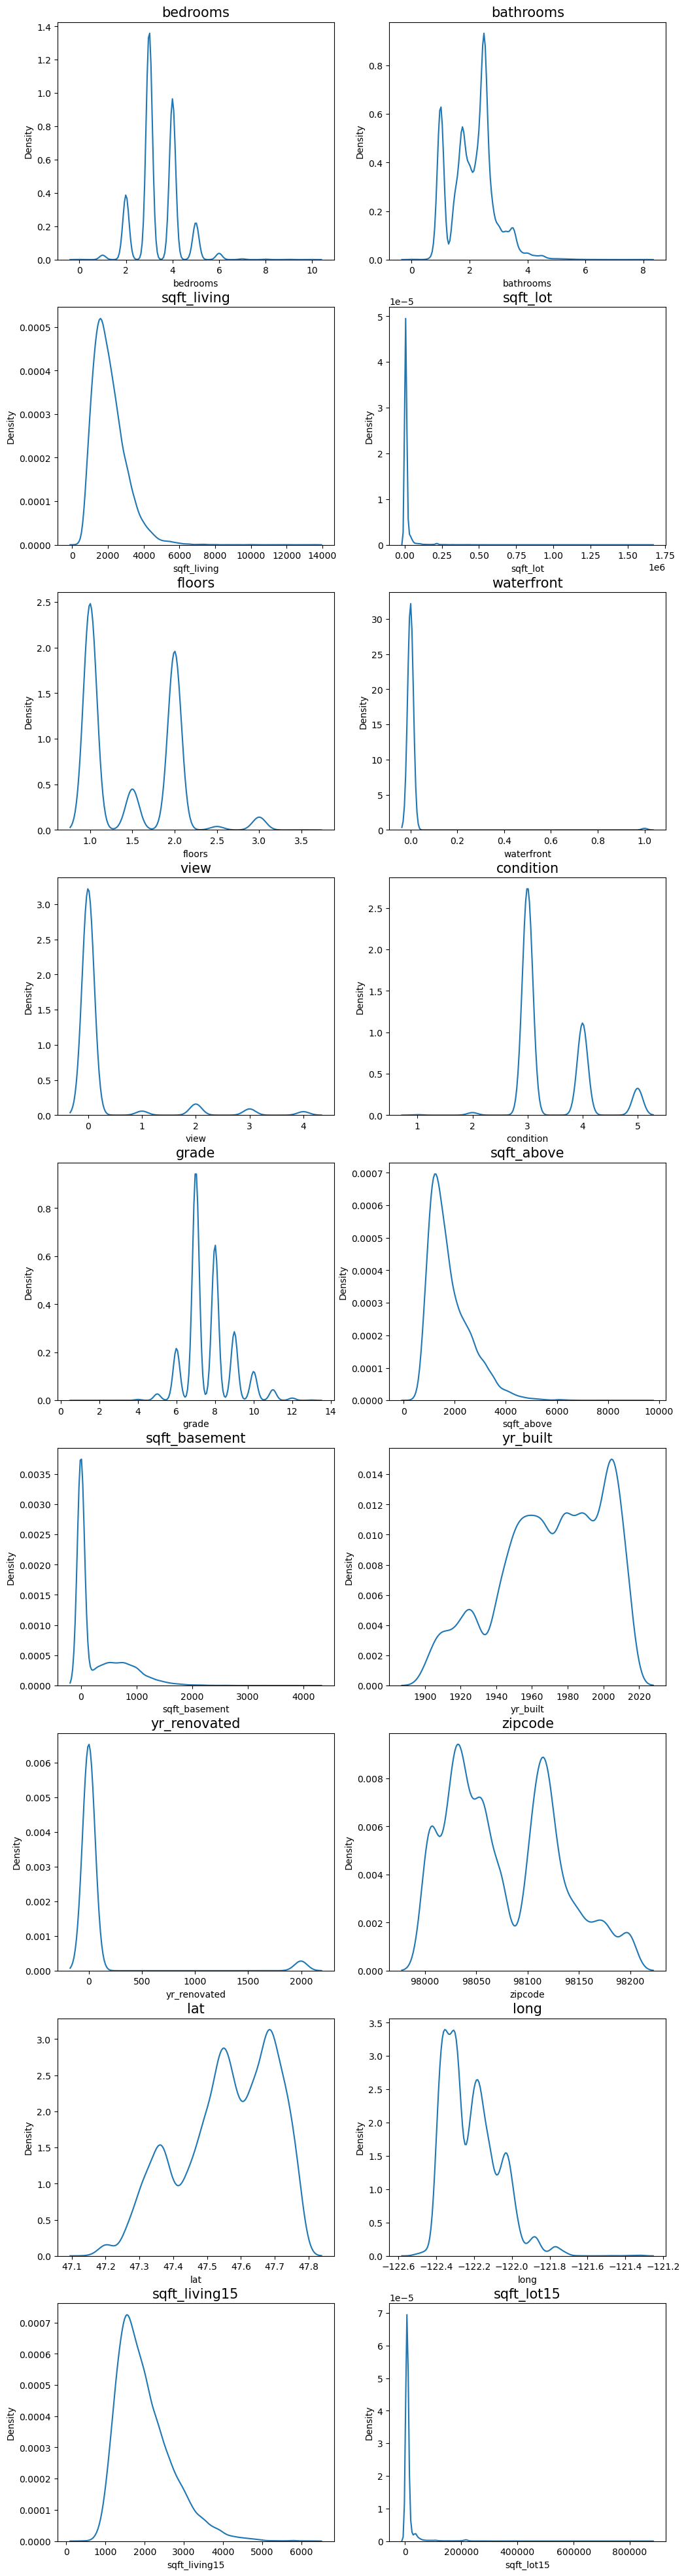

In [98]:
# 정규화를 위한 분포 확인
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

In [99]:
# 정규화 
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [100]:
# 재건축 여부 컬럼 수정
for df in [train, test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [101]:
 # 집의 총 크기, 재건축 여부, 방의 총 수, 지하실 여부, 평당 가격 변수 생성

for df in [train, test]:
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    df['is_basement'] = df['yr_built'].apply(lambda x: 0 if x != 0 else 1)

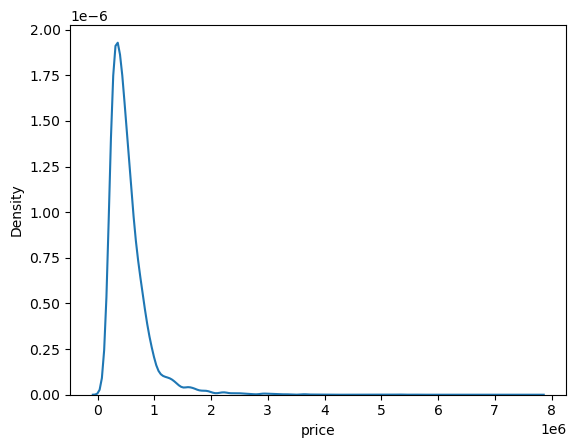

In [102]:
#price 분포 확인
sns.kdeplot(y)
plt.show()

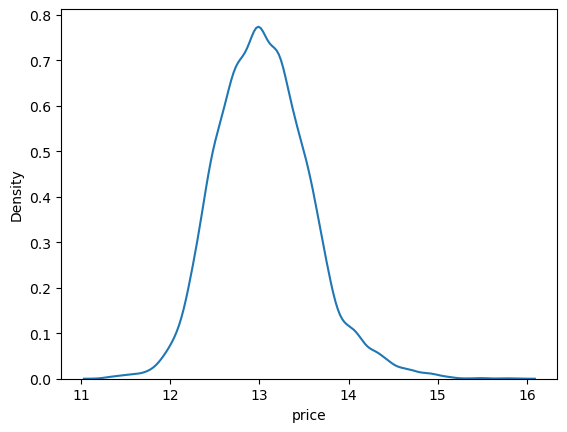

In [103]:
# log1p 로 price 정규화
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [104]:
# 마지막으로 train의 전체 데이터의 자료형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             15035 non-null  int64  
 1   bedrooms         15035 non-null  float64
 2   bathrooms        15035 non-null  float64
 3   sqft_living      15035 non-null  float64
 4   sqft_lot         15035 non-null  float64
 5   floors           15035 non-null  float64
 6   waterfront       15035 non-null  int64  
 7   view             15035 non-null  int64  
 8   condition        15035 non-null  int64  
 9   grade            15035 non-null  int64  
 10  sqft_above       15035 non-null  float64
 11  sqft_basement    15035 non-null  float64
 12  yr_built         15035 non-null  int64  
 13  yr_renovated     15035 non-null  float64
 14  zipcode          15035 non-null  int64  
 15  lat              15035 non-null  float64
 16  long             15035 non-null  float64
 17  sqft_living1

In [105]:
# 대회에서 점수를 매기는 방식인 RMSE 함수 생성
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred))) # 이전에 y를 정규화했기 때문에 expm1 로 다시 복구

In [106]:
# 모델 인스턴스 생성
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [107]:
# 스코어 계산 함수
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [108]:
# GridSearch  함수
def GridSearchFunc(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [109]:
# save_submission 함수
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [ ]:
param_grid = {
    'boosting' : ['goss'],
    'n_estimators': [1400, 1600, 2000],
    'max_depth': [5, 7, 9, 11, 13],
    'learning_rate': [0.015, 0.018, 0.021, 0.024]
}

model = LGBMRegressor(random_state=random_state)
GridSearchFunc(model, train, y, param_grid, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   6.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   6.3s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   6.4s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boosting=goss, learning_rate=0.015, max_depth=5, n_estimators=1400; total time=   7.2s
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[CV] END boost

In [ ]:
model = XGBRegressor(learning_rate=0.024, max_depth=8, n_estimators=1000, random_state=random_state)
model.fit(train, y)

prediction = model.predict(test)
prediction

In [ ]:
prediction = np.expm1(prediction)
prediction